## Importing the Libraries and Loading the Dataset

In [ ]:
## Import necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

!pip install hypopt
from hypopt import GridSearch
## "hypopt" is a python package developed for Grid search hyperparameter optimization and it supports the cases with  
# explicit validation set (we cannot use the Scikit learn Grid Search approach as it uses k-fold cross validation method)

from google.colab import files
from google.colab import output
output.clear()

import random 


In [ ]:
## Load the dataset and create a dataframe
data_to_load = files.upload()
df = pd.read_csv('diabetes.csv')
df.head()

Saving diabetes.csv to diabetes.csv


,Pregnancies,Glucose,Pressure,Insulin,BMI,DPF,Age,Social smoker,Social drinker,Outcome
0,0,86,68,0,35.8,0.238,25,1,0,0
1,0,161,50,0,21.9,0.254,65,0,1,0
2,0,121,66,165,34.3,0.203,33,0,0,1
3,0,117,80,53,45.2,0.089,24,1,1,0
4,0,162,76,100,53.2,0.759,25,1,1,1


## Exploratory Data Analysis and Data Pre-Processing

In [ ]:
## Get some information about columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pregnancies     500 non-null    int64  
 1   Glucose         500 non-null    int64  
 2   Pressure        500 non-null    int64  
 3   Insulin         500 non-null    int64  
 4   BMI             500 non-null    float64
 5   DPF             500 non-null    float64
 6   Age             500 non-null    int64  
 7   Social smoker   500 non-null    int64  
 8   Social drinker  500 non-null    int64  
 9   Outcome         500 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 39.2 KB


In [ ]:
## Check for null and missing values
print(df.isnull().values.any())

False


In [ ]:
## Check for statistical details
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,500.0,3.794000,3.340941,0.000,1.0000,3.0000,6.000,15.000
Glucose,500.0,119.094000,28.666788,33.000,99.0000,114.0000,137.000,189.000
Pressure,500.0,72.392000,12.378076,24.000,64.0000,72.0000,80.000,122.000
Insulin,500.0,86.692000,116.681405,0.000,0.0000,53.0000,135.000,846.000
BMI,500.0,31.971600,6.980559,0.000,27.4000,32.0000,35.925,53.200
DPF,500.0,0.469446,0.326820,0.084,0.2445,0.3725,0.616,2.288
Age,500.0,33.206000,11.772542,21.000,24.0000,29.0000,41.000,81.000
Social smoker,500.0,0.488000,0.500357,0.000,0.0000,0.0000,1.000,1.000
Social drinker,500.0,0.514000,0.500305,0.000,0.0000,1.0000,1.000,1.000
Outcome,500.0,0.332000,0.471403,0.000,0.0000,0.0000,1.000,1.000


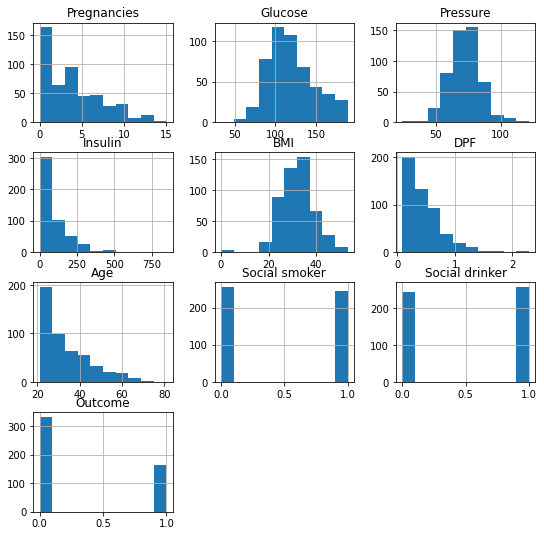

In [ ]:
## check for histograms
df.hist(bins=10,figsize=(9,9))
plt.show()

Based on the information we received from `df.info()`, it seems that there is not any null values in the dataset, but the minimum value of 0 for "BMI" and "Insulin" ( observed in both `df.describe()` and **histograms** ) is meaningless and it might indicate the presence of missing values in these two columns. We need to replace those zeros with NaN and then replacing the NaN's with the "BMI" and "Insulin" mean values. The reason for doing this is to remove the effect of zeros in mean calculations. 
It should be noted that we can replace the zeros with a random sampling number or even median values. Also, we do not remove the rows with missing values as it decrease the size of dataset significantly.

In [ ]:
## Replace the zeros with "NaN"
df[["BMI"]]=df[["BMI"]].replace(0,np.NaN)
df[["Insulin"]]=df[["Insulin"]].replace(0,np.NaN)

In [ ]:
df.isnull().sum()

Pregnancies         0
Glucose             0
Pressure            0
Insulin           221
BMI                 3
DPF                 0
Age                 0
Social smoker       0
Social drinker      0
Outcome             0
dtype: int64

In [ ]:
## Replace the "NaN" values with the mean
df['BMI'].fillna(df['BMI'].mean(), inplace=True)
df['Insulin'].fillna(df['Insulin'].mean(), inplace=True)

In [ ]:
df.isnull().sum()

Pregnancies       0
Glucose           0
Pressure          0
Insulin           0
BMI               0
DPF               0
Age               0
Social smoker     0
Social drinker    0
Outcome           0
dtype: int64

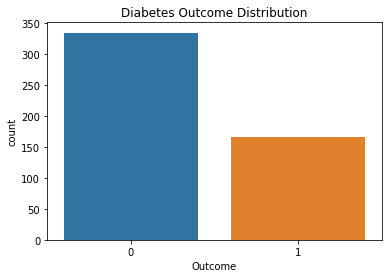

There are a total of 500 observations in this dataset
The number of True outcomes is 166 which is 33.2 percent of the totoal observations
The number of False outcomes is 334 which is 66.8 percent of the totoal observations


In [ ]:
## Check for target variable distribution (i.e., the 'Output' column)
sns.countplot(x = df['Outcome'],label="Count")
plt.title('Diabetes Outcome Distribution') 
plt.show()

print("There are a total of %s observations in this dataset" %(len(df)))
print("The number of True outcomes is %s which is %.1f percent of the totoal observations" 
      %(len(df.loc[df['Outcome']==1]),(len(df.loc[df['Outcome']==1]) / len(df)) * 100))
print("The number of False outcomes is %s which is %.1f percent of the totoal observations" 
      %(len(df.loc[df['Outcome']==0]),(len(df.loc[df['Outcome']==0]) / len(df)) * 100))


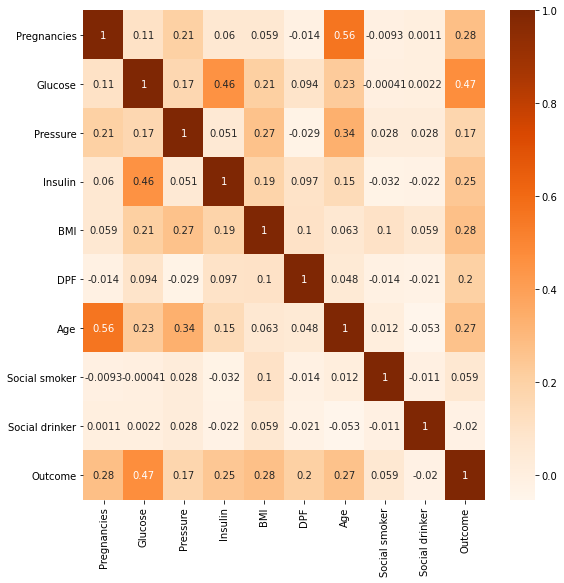

In [ ]:
## Check for correlations
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(df.corr(), cmap='Oranges', annot=True, square=False, ax=ax)
plt.show()


It seems that the features do not have strong correlation with each other and multicollinearity is not an issue in this dataset. 

**Normalization:** KNN algorithms are distance-based algorithms and we need to normalize our data before feeding it to the model in order to achieve a good performance. It is not necessary to normalize the inputs for the other models, however, it is recommended to do that. We do not normalize binary features, i.e. "Social smoker" and "Social drinker".

In [ ]:
## Normalize the numeric features 
SC = StandardScaler()
X_to_be_SC = df.drop(['Outcome','Social smoker','Social drinker'], axis=1)
X_SC = pd.DataFrame(SC.fit_transform(X_to_be_SC), columns=X_to_be_SC.columns)
X_SC.head()

,Pregnancies,Glucose,Pressure,Insulin,BMI,DPF,Age
0,-1.136745,-1.155593,-0.355176,0.000000,0.557905,-0.708885,-0.697744
1,-1.136745,1.463295,-1.810817,0.000000,-1.575246,-0.659880,2.703396
2,-1.136745,0.066555,-0.516914,0.110308,0.327709,-0.816085,-0.017516
3,-1.136745,-0.073119,0.615251,-1.171541,2.000468,-1.165251,-0.782772
4,-1.136745,1.498214,0.291775,-0.633623,3.228180,0.886862,-0.697744


In [ ]:
## Specify the feature and target datasets [X and y]
X = pd.concat([X_SC, df[['Social smoker','Social drinker']] ], axis=1 )
y = df[['Outcome']]

In [ ]:
## Split the dataset into training, validation, and test sets  (50,30,20 ratios)

random_state=32
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=random_state, stratify=y) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3/0.8, random_state=random_state, stratify=y_train) 
# The reason that we set a value for "stratify" parameter is to have the same proportion of outcomes in training, validation, and test sets.

print("Training set size is: %s (%.f percent) " %(len(X_train),len(X_train)/len(df)*100))
print("Validation set size is: %s (%.f percent) " %(len(X_valid),len(X_valid)/len(df)*100))
print("Test set size is: %s (%.f percent) " %(len(X_test),len(X_test)/len(df)*100))


Training set size is: 250 (50 percent) 
Validation set size is: 150 (30 percent) 
Test set size is: 100 (20 percent) 


In [ ]:
## Ensure that the distribution of target variable in training, validation, and test sets is similar to the original dataset

outcome_dist = []
Sets = ['Original dataset', 'Training set', 'Validation set', 'Test set']
j = 0
for i in [y, y_train, y_valid, y_test]:
  outcome_0_percent = (len(i.loc[i['Outcome']==0]) / len(i)) * 100
  outcome_1_percent = (len(i.loc[i['Outcome']==1]) / len(i)) * 100
  i_dist = [ Sets[j], outcome_0_percent, outcome_1_percent]
  outcome_dist.append(i_dist)
  j += 1
outcome_dists = pd.DataFrame(outcome_dist, columns=['Set', 'Outcome=0', 'Outcome=1'])
outcome_dists


,Set,Outcome=0,Outcome=1
0,Original dataset,66.800000,33.200000
1,Training set,66.800000,33.200000
2,Validation set,66.666667,33.333333
3,Test set,67.000000,33.000000


## Hyper-parameter Optimization

Given that the hyper-parameter optimization results depend on which samples are used as validation set, we generate 100 random numbers between 1 and 1000 to use them as `random_state` parameter and build 100 different splits of the dataset. A function named `tune()` is written to handle the optimization process. In fact, this function will be called inside another function (`evaluate()`) where by calling it on a model name, for each of the 100 random numbers, the dataset is split into three parts and the hyper-parameters are optimized on the generated validation set and also evaluated on the test set. By doing this, each model is validated and evaluated 100 times. In the end, the results are presented as box plots and also as a table of descriptive statistics in order to make comparisons easier.

In [ ]:
## Generate random numbers (to use them for the random_state parameter)

random_iterations = range(0,100)
randomlist = [] 
for i in random_iterations: 
  n = random.randint(1,1000) 
  randomlist.append(n)
randomlist[:10]

[313, 837, 633, 79, 780, 718, 952, 153, 378, 401]

In [ ]:
## hyper-parameter sets
c_set = np.logspace(-2, 2, 10)
n_neighbors_set = range(1,25)
param_grid_tree= {
                "criterion":['gini','entropy'],
                "max_depth":range(1,10),
                "min_samples_split":range(2,10), 
                "min_samples_leaf":range(1,10),
  }
param_grid_mlp = {
      'hidden_layer_sizes': [(50,50), (50,50,50)],
      'activation': ['tanh', 'relu'],
      'solver': ['sgd', 'adam'],
      'alpha': [0.01, 0.1, 1],
      'learning_rate': ['constant','adaptive'],
  }

For the purpose of hyper-parameter optimization, we use Grid Search approach where the model is trained using a set of parameters and evaluated on a validation set. The set of parameters that make the model have the best performance on validation set is selected as the optimal set. The popular Sckit Learn package provides such an approach but it validated the models using K-fold Cross Validation score where there is no explicit validation set. As we have explicit validation sets, we utilize another package called "hypopt" which provides Grid Search method for both cases of having implicit (K-fold Cross Validation) and explicit validation set. 

In [ ]:
## Define a function for hyper-parameter tuning 

def tune(model_name, X_train, X_valid, y_train, y_valid):
  """ This function takes 5 parameters and returns the optimal parameters and the respective validation accuracy.
  it is called inside the evaluate function where all theses required parameters are defined and specified """ 
  Valid_Acc_list = []
  if model_name == 'LogReg':
    for c in c_set:
      model = LogisticRegression(C=c)
      model.fit(X_train,y_train)
      Valid_Acc_list.append(model.score(X_valid,y_valid))
    best_param = c_set[np.argmax(Valid_Acc_list)]
    best_valid_acc = max(Valid_Acc_list)
  elif model_name == 'knn':
    for n_neighbors in n_neighbors_set:
      model = KNeighborsClassifier(n_neighbors)
      model.fit(X_train,y_train)
      Valid_Acc_list.append(model.score(X_valid,y_valid))
    best_param = n_neighbors_set[np.argmax(Valid_Acc_list)]
    best_valid_acc = max(Valid_Acc_list)
  elif model_name == 'tree':
    model = DecisionTreeClassifier()
    best_model = GridSearch(model = model, param_grid = param_grid_tree)
    best_model.fit(X_train, y_train, X_valid, y_valid)
    for parameter,score in best_model.get_param_scores():
      Valid_Acc_list.append(score)
      if score >= max(Valid_Acc_list):
        best_param = parameter
    best_valid_acc = max(Valid_Acc_list)
  else:
    model = MLPClassifier(max_iter=1000)
    best_model = GridSearch(model = model , param_grid = param_grid_mlp)
    best_model.fit(X_train, y_train, X_valid, y_valid)
    for parameter,score in best_model.get_param_scores():
      Valid_Acc_list.append(score)
      if score >= max(Valid_Acc_list):
        best_param = parameter
    best_valid_acc = max(Valid_Acc_list)
  return best_param , best_valid_acc



## Model Evaluation

In this section, a function is written to handle the evaluation process of each model. The `evaluate()` function takes two parameters of `model_name` and `n_runs` and returns the evaluation results as a table. Indeed, by using the first `n_runs` random numbers generated before, each model is evaluated `n_runs` times and the results of the runs can be visualized as box plots for the purpose of comparisons. In other words, the models can be compared to each other using their descriptive statistics of evaluation results. 

In [ ]:
## Define a function for the evaluation 

def evaluate(model_name,n_run):
  """ This function takes one of these model names: {'LogReg', 'knn','tree','mlp'} and it returns the validation
   and evaluation results of the model on validation and test sets that have been created using the first n_run
   random numbers fromm the previously generated randomlist.
  """
  Results = []
  for s in randomlist[:n_run]:

    ## create training, validation, and test sets (50% for training set, 30% for validation set, 20% for test set)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=s, stratify=y) 
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3/0.8, random_state=s, stratify=y_train) 
    
    ## tune/validate the model 
    best_param, best_valid_acc= tune(model_name, X_train, X_valid, y_train, y_valid)

    ## initialize the validated model
    if model_name == 'LogReg':
      model = LogisticRegression(C = best_param)
    elif model_name == 'knn':
      model = KNeighborsClassifier(n_neighbors = best_param)
    elif model_name == 'tree':
      model = DecisionTreeClassifier(criterion=best_param['criterion'],                  
                                  max_depth=best_param['max_depth'], 
                                  min_samples_split=best_param['min_samples_split'], 
                                  min_samples_leaf=best_param['min_samples_leaf'],
                                  random_state=s)
    else:
      model = MLPClassifier(hidden_layer_sizes=best_param['hidden_layer_sizes'],          
                        activation=best_param['activation'], 
                        solver=best_param['solver'],
                        alpha=best_param['alpha'],
                        learning_rate=best_param['learning_rate'],
                        max_iter=1000, 
                        random_state=s)
      
    ## Re-train the validated model on the training set
    model.fit(X_train, y_train.values.ravel())

    ## Evaluate the model on test set
    y_pred = model.predict(X_test)
    test_accuracy = model.score(X_test,y_test)
    TP = confusion_matrix(y_test, y_pred)[0, 0]
    FP = confusion_matrix(y_test, y_pred)[1, 0]
    TN = confusion_matrix(y_test, y_pred)[1, 1]
    FN = confusion_matrix(y_test, y_pred)[0, 1]
    Result = [s, type(model).__name__,best_param, best_valid_acc, test_accuracy, TP/(TP+FN), TN/(TN+FP)]
    Results.append(Result)
  Results = pd.DataFrame(Results, columns=['random_state', 'Model',  'Hyper-parameters',  'Validation Accuracy', 'Test Accuracy', 'Sensitivity', 'Specificity'])
  return Results


In [ ]:
## see an example: evaluation of knn model with the first 3 random numbers from the generated randomlist
log_reg_results = evaluate('knn',3)
output.clear()
log_reg_results

,random_state,Model,Hyper-parameters,Validation Accuracy,Test Accuracy,Sensitivity,Specificity
0,313,KNeighborsClassifier,20,0.813333,0.79,0.955224,0.454545
1,837,KNeighborsClassifier,23,0.806667,0.75,0.910448,0.424242
2,633,KNeighborsClassifier,14,0.786667,0.81,0.940299,0.545455


Accuracy is not a good measure of classification performance especially when it comes to having an unbalanced dataset which is in this case. In medical diagnostics, both sensitivity and specificity must be taken into account in order to determine the best diagnostic test.
The former is a measure of how well a test can identify sick people and the latter measures how well a test can identify healthy people. 
The Confusion matrix, sensitivity, and specificity are defined as below:

|               |  |Predicted Label   |                   |
|---------------|--|------------------|-------------------|
|               |  |         1        |          0        |
|**True Label** |1 |  True Positive   |  False Negative   |
|               |0 |  False Positive  |  True Negative    |

* **True Positive - TP:** Sick people correctly identified as sick
* **False Positive - FP:** Healthy people incorrectly identified as sick
* **True Negative - TN:** Healthy people correctly identified as healthy
* **False Negative - FN:** Sick people incorrectly identified as healthy
* **Sensitivity** or true positive rate  (TPR) = TP / (TP+FN) **-->** The ratio of people who are correctly diagnosed as having diabetes
* **Specificity** or true negative rate  (TNR) = TN / (TN+FP) **-->** The ratio of people who are correctly diagnosed as not having diabetes

The following table shows the average of 100 runs achieved in evaluation section (next section). It seems that the both MLP and Logistic Resgression classifiers have the highest average accuracy of around 77% on the test set. However in terms of sensitivity and specificity, the MLP maintains a balance between the two metrics and hence, it can be selected as the best model. The average values of sensitivity and specificity achieved by the MLP classifier are 0.866 and 0.578, respectively. This means that for each 100 individuals having diabetes, this classifier is able to detect 87 of them correctly and for each 100 individuals who do not have diabetes, this classifier is able to detect 58 of them correctly.

|     Model             |Accuracy |Sensitivity|Specificity|
|-----------------------|---------|-----------|-----------|
|LogisticRegression     |  0.773  |  0.914    |   0.487   |
|KNeighborsClassifier   |  0.761  |  0.897    |   0.487   |    
|DecisionTreeClassifier |  0.745  |  0.841    |   0.550   |          
|MLPClassifier          |  0.771  |  0.866    |   0.578   |



In [ ]:
## Evaluate the models

model_names = ['LogReg', 'knn', 'tree', 'mlp']
n_run = 100
LogReg_results = evaluate('LogReg',n_run)
knn_results = evaluate('knn',n_run)
tree_results = evaluate('tree',n_run)
mlp_results = evaluate('mlp',n_run)

output.clear()

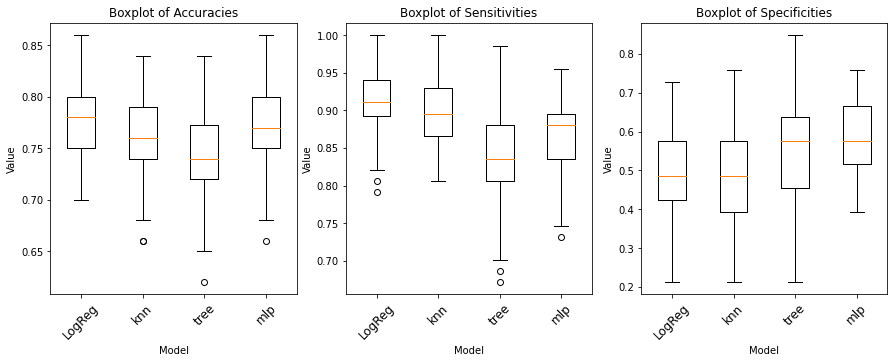

In [ ]:
## Box Plots

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

ax1.boxplot([LogReg_results['Test Accuracy'], knn_results['Test Accuracy'], tree_results['Test Accuracy'], mlp_results['Test Accuracy'] ] )
ax1.set(title='Boxplot of Accuracies', xlabel='Model', ylabel='Value')
ax1.set_xticklabels(model_names, rotation=45, fontsize=12)

ax2.boxplot([LogReg_results['Sensitivity'], knn_results['Sensitivity'], tree_results['Sensitivity'], mlp_results['Sensitivity'] ] )
ax2.set(title='Boxplot of Sensitivities', xlabel='Model', ylabel='Value')
ax2.set_xticklabels(model_names, rotation=45, fontsize=12)

ax3.boxplot([LogReg_results['Specificity'], knn_results['Specificity'], tree_results['Specificity'], mlp_results['Specificity'] ] )
ax3.set(title='Boxplot of Specificities', xlabel='Model', ylabel='Value')
ax3.set_xticklabels(model_names, rotation=45, fontsize=12)


plt.show()

In [ ]:
## tables of statistics

eveluation_results = [LogReg_results, knn_results, tree_results, mlp_results]

for evaluation_result in eveluation_results:
  print('Statistics of results for the', evaluation_result.iloc[0]['Model'],'in {} runs'.format(n_run))
  print(evaluation_result.describe().T.drop(['count','25%','50%','75%'], axis = 1).drop("random_state", axis=0) , '\n', '\n')


Statistics of results for the LogisticRegression in 100 runs
                         mean       std       min        max
Hyper-parameters     0.546416  1.621243  0.010000  12.915497
Validation Accuracy  0.779400  0.024820  0.693333   0.833333
Test Accuracy        0.772700  0.033329  0.700000   0.860000
Sensitivity          0.913582  0.045315  0.791045   1.000000
Specificity          0.486667  0.114346  0.212121   0.727273 
 

Statistics of results for the KNeighborsClassifier in 100 runs
                          mean       std       min        max
Hyper-parameters     13.010000  6.186487  2.000000  24.000000
Validation Accuracy   0.789333  0.021462  0.740000   0.846667
Test Accuracy         0.761400  0.037927  0.660000   0.840000
Sensitivity           0.896567  0.042442  0.805970   1.000000
Specificity           0.486970  0.108642  0.212121   0.757576 
 

Statistics of results for the DecisionTreeClassifier in 100 runs
                         mean       std       min       max
Valid